In [1]:
# Import necessary packages: These include custom MOSAIKS packages contained within the repo, as well as standard Python packages.
%load_ext autoreload
%autoreload 2
%matplotlib inline

import io as b_io
import os
from pathlib import Path

import dill

# Import necessary packages
from mosaiks import config as c
from mosaiks import transforms
from mosaiks.utils import OVERWRITE_EXCEPTION
from mosaiks.utils.imports import *
from threadpoolctl import threadpool_limits

env variable MOSAIKS_HOME not defined; setting to: "/home/ubuntu/cs230/mosaiks-paper"
If not desired, please reset os.environ["MOSAIKS_NAME"]


In [2]:
num_threads = None

subset_n = slice(None)
subset_feat = slice(None)

overwrite = True

fixed_lambda = False

labels_to_run = "all"


if num_threads is not None:
    threadpool_limits(num_threads)
    os.environ["NUMBA_NUM_THREADS"] = str(num_threads)

if overwrite is None:
    overwrite = os.getenv("MOSAIKS_OVERWRITE", False)
if labels_to_run == "all":
    labels_to_run = c.app_order
    
solver = solve.ridge_regression

In [3]:
X = {}
latlons = {}

for sample in ["UAR", "POP"]:
    # path to features X for UAR
    features_path = (
        Path(c.features_dir)
        / f"{c.features['pretrained']['model_type']}_pretrained_{c.grid['area']}_{c.images['zoom_level']}_{c.images['n_pixels']}_{sample}.pkl"
    )
    with open(features_path, "rb") as f:
        data = dill.load(f)
    features = data["X"].astype(np.float64)
    latlons_samp = data["latlon"]
    ids_x = data["ids_X"]

    X[sample] = pd.DataFrame(features, index=ids_x)
    latlons[sample] = pd.DataFrame(latlons_samp, index=ids_x, columns=["lat", "lon"])

In [16]:
labels_to_run = ["housing"]

In [17]:
resultsDict = {}
label = labels_to_run[0]

print("*** Running regressions for: {}".format(label))

## Set some label-specific variables
this_cfg = io.get_filepaths(c, label)
c_app = getattr(this_cfg, label)
outcome_name = c_app["variable"]
sampling_type = c_app["sampling"]  # UAR or POP

best_lambda_fpath = join(c.fig_dir_sec, "best_lambda_tl.npz")
if fixed_lambda:
    lambdas = io.get_lambdas(c, label, best_lambda_fpath=best_lambda_fpath)
else:
    lambdas = io.get_lambdas(c, label, best_lambda_fpath=None)

if c_app["logged"]:
    bounds = np.array([c_app["us_bounds_log_pred"]])
else:
    bounds = np.array([c_app["us_bounds_pred"]])

# Set solver arguments
solver_kwargs = {
    "lambdas": lambdas,
    "return_preds": True,
    "svd_solve": False,
    "clip_bounds": bounds,
}

# Expand possible lambdas for this transfer learning feature set as needed so that
# the optimal lambda selected is not hitting the bounds of possible lambdas.
if (not fixed_lambda) and (label in ["income", "roads"]):
    solver_kwargs["lambdas"] = np.logspace(-3, 4, 9)

## get X, Y, latlon values of training data
(
    this_X,
    this_X_test,
    this_Y,
    this_Y_test,
    _,
    _,
) = parse.merge_dropna_transform_split_train_test(
    this_cfg, label, X[sampling_type], latlons[sampling_type]
)

## subset
this_X = this_X[subset_n, subset_feat]
this_X_test = this_X_test[:, subset_feat]
this_Y = this_Y[subset_n]

## Train model using ridge regression and 5-fold cross-valiation
## (number of folds can be adjusted using the argument n_folds)
print("Training model...")
kfold_results = solve.kfold_solve(
    this_X,
    this_Y,
    solve_function=solver,
    num_folds=this_cfg.ml_model["n_folds"],
    return_model=True,
    **solver_kwargs
)
print("")

## Store the metrics and the predictions from the best performing model
best_lambda_idx, best_metrics, best_preds = ir.interpret_kfold_results(
    kfold_results, "r2_score", hps=[("lambdas", solver_kwargs["lambdas"])]
)
best_lambdas = np.array(
    [solver_kwargs["lambdas"][np.asarray(best_lambda_idx).squeeze()]]
)

# save best lambdas
if subset_n == slice(None) and subset_feat == slice(None):
    np.savez(best_lambda_fpath, best_lambda=best_lambdas)

## Retrain a model using this best lambda:
holdout_results = solve.single_solve(
    this_X,
    this_X_test,
    this_Y,
    this_Y_test,
    lambdas=best_lambdas,
    return_preds=True,
    return_model=False,
    clip_bounds=bounds,
    svd_solve=False,
)

## Store the R2
resultsDict[label] = holdout_results["metrics_test"][0][0][0]["r2_score"]

*** Running regressions for: housing
Loading labels...
Merging labels and features...
Splitting training/test...
Training model...
on fold (of 5): 1 2 3 4 5 

/home/ubuntu/cs230/mosaiks-paper/code/mosaiks/solve/solve_functions.py:364: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "y_true_test": np.array(kfold_y_test),
/home/ubuntu/cs230/mosaiks-paper/code/mosaiks/solve/solve_functions.py:365: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "y_true_train": np.array(kfold_y_train),


Plotting log_price_per_sqft...


/home/ubuntu/anaconda3/envs/mosaiks-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ubuntu/anaconda3/envs/mosaiks-env/lib/python3.9/site-packages/seaborn/axisgrid.py:2073: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


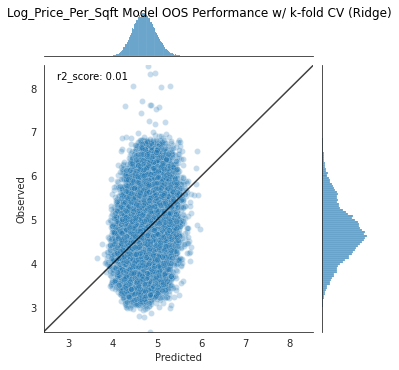

In [18]:
plots.performance_density(
    kfold_results,
    "Ridge",
    val=outcome_name,
    save_dir=None,
    app_name=label,
    kind="scatter",
    size=5
)